In [1]:
!pip install pgmpy --quiet # It will take some time ...

## Inference with a Bayesian Network

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.utils import get_example_model

### Loading the Alarm Bayesian Network

In [3]:
# Load the model (hint: get_example_model).
model = get_example_model("alarm")

print(model)

DiscreteBayesianNetwork named 'unknown' with 37 nodes and 46 edges


### Visualiza the Graph

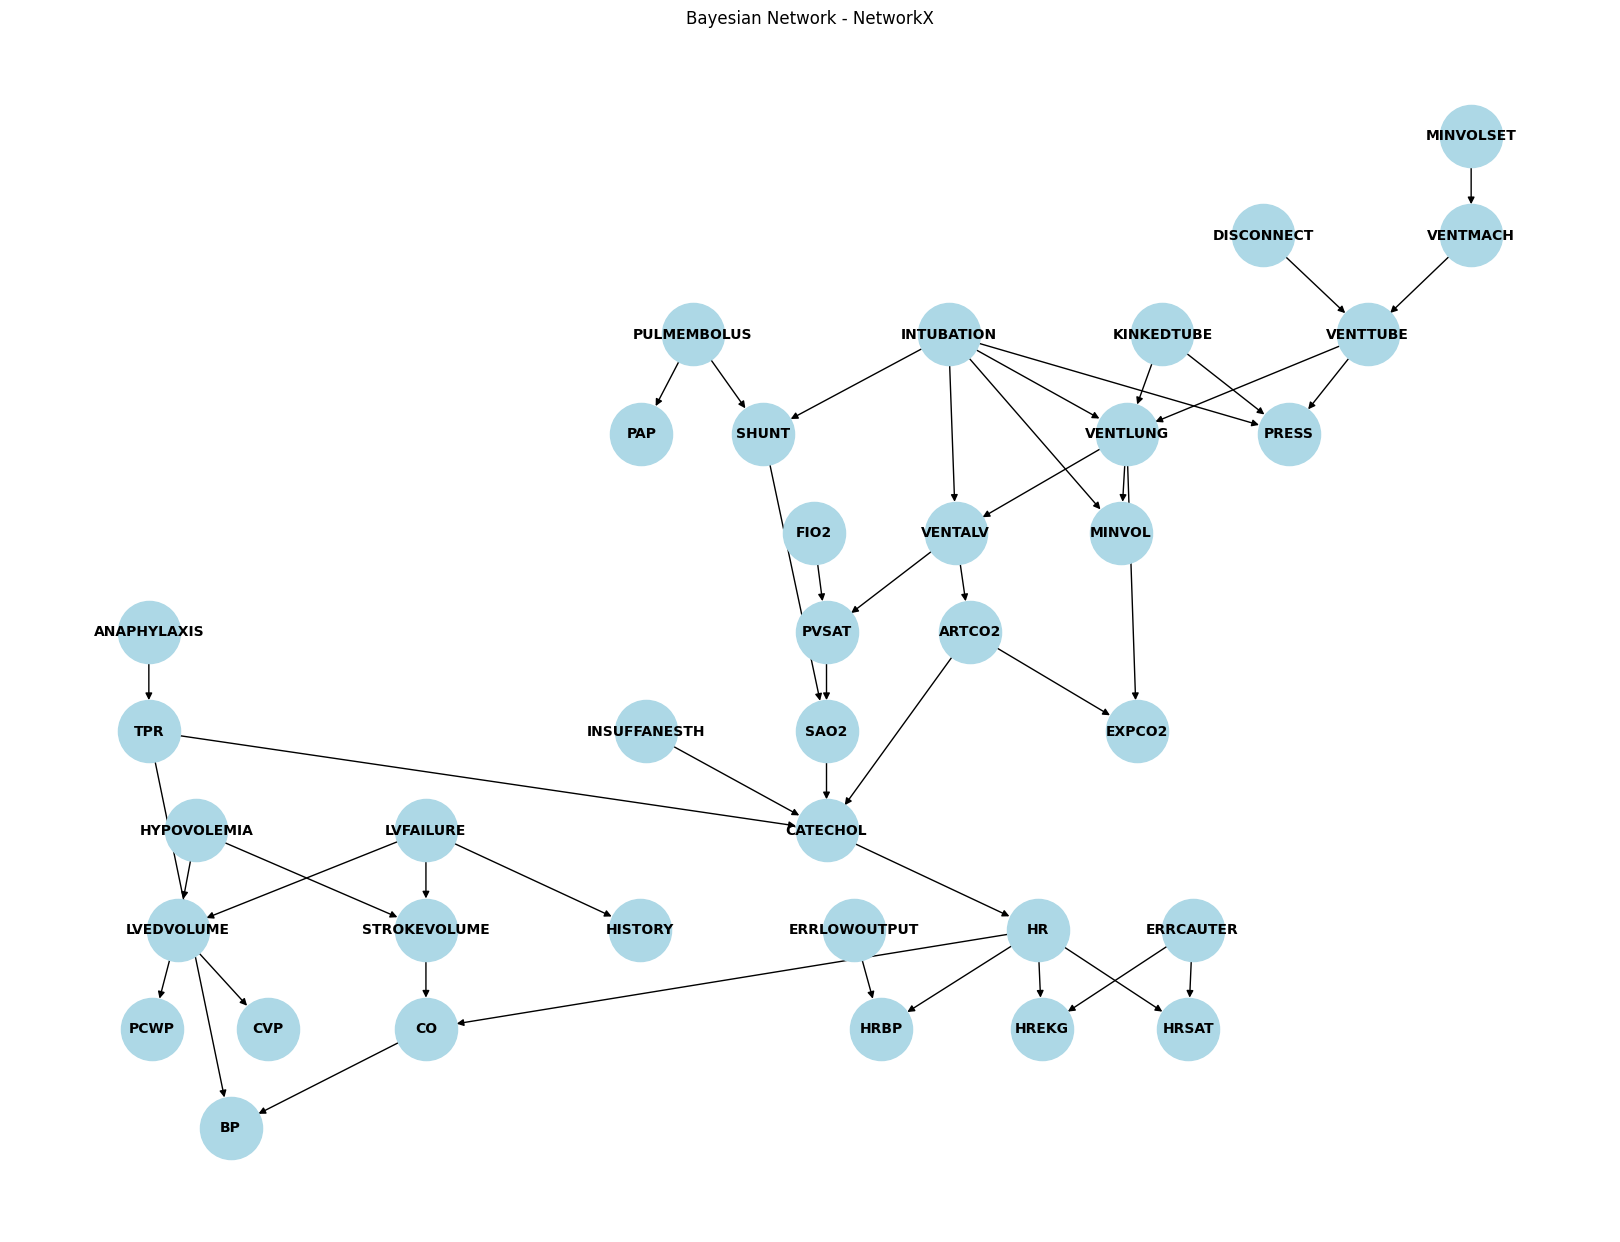

In [4]:
# Visualization using Graphviz layout (hint: nx.nx_pydot.graphviz_layout).
plt.figure(figsize=(16, 12))
G = nx.DiGraph(model.edges())
nx.draw(
    G,
    pos=nx.nx_pydot.graphviz_layout(G, prog="dot"),
    with_labels=True,
    node_color='lightblue',
    edge_color='black',
    node_size=2000,
    font_size=10,
    font_weight='bold'
)
plt.title("Bayesian Network - NetworkX")
plt.show()

### Exact Inference

In [5]:
from pgmpy.inference import VariableElimination

# Construct the inference engine.
inference_engine = VariableElimination(model)

#### Compute the marginal probability of P(VENTLUNG)

In [6]:
# Compute the probability of lung ventilation.
p_ventlung = inference_engine.query(["VENTLUNG"])

print(p_ventlung)

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.7426 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.2200 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0116 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0257 |
+------------------+-----------------+


#### Compute joint probability of P(VENTLUNG, INTUBATION)

In [7]:
# Compute the joint probability of lung ventilation and intubation.
p_ventlung_intubation = inference_engine.query(["VENTLUNG", "INTUBATION"])

print(p_ventlung_intubation)

+------------------+------------------------+----------------------------+
| VENTLUNG         | INTUBATION             |   phi(VENTLUNG,INTUBATION) |
+==================+========================+============================+
| VENTLUNG(ZERO)   | INTUBATION(NORMAL)     |                     0.7032 |
+------------------+------------------------+----------------------------+
| VENTLUNG(ZERO)   | INTUBATION(ESOPHAGEAL) |                     0.0175 |
+------------------+------------------------+----------------------------+
| VENTLUNG(ZERO)   | INTUBATION(ONESIDED)   |                     0.0220 |
+------------------+------------------------+----------------------------+
| VENTLUNG(LOW)    | INTUBATION(NORMAL)     |                     0.1854 |
+------------------+------------------------+----------------------------+
| VENTLUNG(LOW)    | INTUBATION(ESOPHAGEAL) |                     0.0103 |
+------------------+------------------------+----------------------------+
| VENTLUNG(LOW)    | INTU

#### Compute conditional probability of P(VENTLUNG | INTUBATION = ESOPHAGEAL)

In [8]:
# Compute the probability of lung ventilation knowing that intubation is esophageal.
p_ventlung_given_intubation = inference_engine.query(
    variables = ["VENTLUNG"],
    evidence = {"INTUBATION": "ESOPHAGEAL"}
)

print(p_ventlung_given_intubation)

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.5843 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.3419 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0638 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0100 |
+------------------+-----------------+


#### Compute P(VENTLUNG, VENTALV | INTUBATION = ESOPHAGEAL, VENTTUBE = LOW)

In [9]:
p_vv_ie_vl = inference_engine.query(
    variables = ["VENTLUNG", "VENTALV"],
    evidence = {"INTUBATION": "ESOPHAGEAL", "VENTTUBE": "LOW"}
)

print(p_vv_ie_vl)

+------------------+-----------------+-------------------------+
| VENTLUNG         | VENTALV         |   phi(VENTLUNG,VENTALV) |
+==================+=================+=========================+
| VENTLUNG(ZERO)   | VENTALV(ZERO)   |                  0.0052 |
+------------------+-----------------+-------------------------+
| VENTLUNG(ZERO)   | VENTALV(LOW)    |                  0.5032 |
+------------------+-----------------+-------------------------+
| VENTLUNG(ZERO)   | VENTALV(NORMAL) |                  0.0052 |
+------------------+-----------------+-------------------------+
| VENTLUNG(ZERO)   | VENTALV(HIGH)   |                  0.0052 |
+------------------+-----------------+-------------------------+
| VENTLUNG(LOW)    | VENTALV(ZERO)   |                  0.4474 |
+------------------+-----------------+-------------------------+
| VENTLUNG(LOW)    | VENTALV(LOW)    |                  0.0046 |
+------------------+-----------------+-------------------------+
| VENTLUNG(LOW)    | VENT

#### Get the state with maximum probability from the previous queries

In [10]:
# MAP(VENTLUNG)
print(inference_engine.map_query(["VENTLUNG"]))
# MAP(VENTLUNG, INTUBATION)
print(inference_engine.map_query(["VENTLUNG", "INTUBATION"]))
# MAP(VENTLUNG | INTUBATION = ESOPHAGEAL)
print(inference_engine.map_query(
    variables = ["VENTLUNG"],
    evidence = {"INTUBATION": "ESOPHAGEAL"}
))
# MAP(VENTLUNG, VENTALV | INTUBATION = ESOPHAGEAL, VENTUBE = LOW)
print(inference_engine.map_query(
    variables = ["VENTLUNG", "VENTALV"],
    evidence = {"INTUBATION": "ESOPHAGEAL", "VENTTUBE": "LOW"}
))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'VENTLUNG': 'ZERO'}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'INTUBATION': 'NORMAL', 'VENTLUNG': 'ZERO'}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'VENTLUNG': 'ZERO'}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'VENTLUNG': 'ZERO', 'VENTALV': 'LOW'}


### Approximate Inference

In [11]:
from pgmpy.inference import ApproxInference

# Construct the inference engine.
approx_inference_engine = ApproxInference(model)

#### Compute P(VENTLUNG) with different samples

In [12]:
samples = [100, 1_000, 10_000, 100_000]
approx_p_ventlung = []

for n in samples:
    _p = approx_inference_engine.query(
        ["VENTLUNG"],
        n_samples=n,
        seed=42
    )
    print(_p)
    approx_p_ventlung.append(_p)

  0%|          | 0/37 [00:00<?, ?it/s]

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.7400 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.2200 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0300 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0100 |
+------------------+-----------------+


/usr/local/lib/python3.12/dist-packages/pgmpy/inference/ApproxInference.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples.groupby(variables).size() / samples.shape[0], state_names


  0%|          | 0/37 [00:00<?, ?it/s]

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.7290 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.2320 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0120 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0270 |
+------------------+-----------------+


/usr/local/lib/python3.12/dist-packages/pgmpy/inference/ApproxInference.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples.groupby(variables).size() / samples.shape[0], state_names


  0%|          | 0/37 [00:00<?, ?it/s]

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.7407 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.2203 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0252 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0138 |
+------------------+-----------------+


/usr/local/lib/python3.12/dist-packages/pgmpy/inference/ApproxInference.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples.groupby(variables).size() / samples.shape[0], state_names


  0%|          | 0/37 [00:00<?, ?it/s]

+------------------+-----------------+
| VENTLUNG         |   phi(VENTLUNG) |
+==================+=================+
| VENTLUNG(ZERO)   |          0.7432 |
+------------------+-----------------+
| VENTLUNG(LOW)    |          0.2195 |
+------------------+-----------------+
| VENTLUNG(HIGH)   |          0.0254 |
+------------------+-----------------+
| VENTLUNG(NORMAL) |          0.0119 |
+------------------+-----------------+


/usr/local/lib/python3.12/dist-packages/pgmpy/inference/ApproxInference.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  samples.groupby(variables).size() / samples.shape[0], state_names


In [13]:
# Collect the approximate queries.
all_p_ventlung = pd.DataFrame({
    ("APPROX_" + str(n)): p.values
    for (n, p) in zip(samples, approx_p_ventlung)
})
# Add the exact query.
all_p_ventlung["EXACT"] = p_ventlung.values
# Set the index.
all_p_ventlung.index = p_ventlung.state_names["VENTLUNG"]

all_p_ventlung

,APPROX_100,APPROX_1000,APPROX_10000,APPROX_100000,EXACT
ZERO,0.74,0.729,0.7407,0.74318,0.742639
LOW,0.22,0.232,0.2203,0.21950,0.219990
NORMAL,0.03,0.012,0.0252,0.02541,0.011644
HIGH,0.01,0.027,0.0138,0.01191,0.025727


<Axes: >

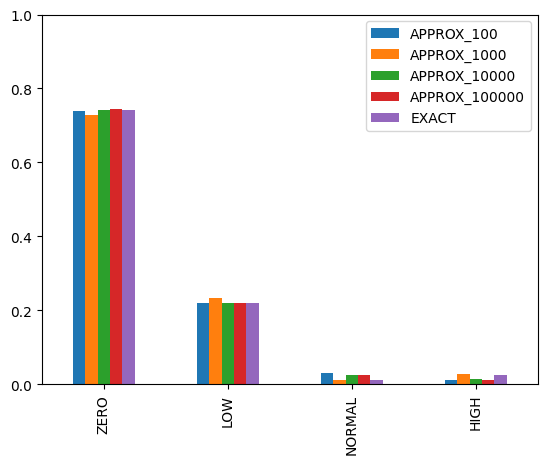

In [14]:
all_p_ventlung.plot.bar(ylim=(0, 1))